In [14]:
import torch
import torchaudio
import cv2
import seaborn as sns
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# Подготовка данных

In [3]:
# Просмотр данных

flowers_dir = r"data/flowers"

all_image_paths = []

for folder in os.listdir(flowers_dir):
    folder_path = os.path.join(flowers_dir, folder)
    if os.path.isdir(folder_path):
        all_image_paths += [os.path.join(folder_path, fname)
                            for fname in os.listdir(folder_path)
                            if fname.endswith(".jpg")]
        
random.shuffle(all_image_paths)

In [4]:
# Дробим сет данных 90 процентов библиотека в 10 процентах запросы
split_index = int(0.9 * len(all_image_paths))
library_paths = all_image_paths[:split_index]
query_paths = all_image_paths[split_index:split_index + 5]  # 5 случайных для визуализации

In [5]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],  # стандарт для ImageNet
                                                     std=[0.229, 0.224, 0.225])])

# Обучение

In [6]:
# Выбираем устройство на котором будет обучаться модел, в моём случае это CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Загрузка ResNet50 без классификатора
base_model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(base_model.children())[:-1])  # удаляем классификатор
model = model.to(device).eval()

d:\A_projects\Test_Task\Flower_Recognizer\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\A_projects\Test_Task\Flower_Recognizer\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\kolyagin/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


In [11]:
# Функция для получение эмбеддингов
def get_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        embedding = model(image_tensor).squeeze().cpu().numpy()
    return embedding.flatten()

In [12]:
# Получение эмбедингов библиотеки
library_embeddings = []
for path in tqdm(library_paths, desc="Embedding library"):
    emb = get_embedding(path)
    library_embeddings.append(emb)
library_embeddings = np.array(library_embeddings)

Embedding library: 100%|██████████| 3885/3885 [02:43<00:00, 23.76it/s]


In [18]:
em_path = r"app\model\embeddingsembeddings.npy"
# Сохранение эмбеддингов
embeddings = np.array(library_embeddings)
np.save(em_path, embeddings)
print(f"Сохранено {len(embeddings)} эмбеддингов в {em_path}")

Сохранено 3885 эмбеддингов в app\model\embeddingsembeddings.npy


# Тестирование 

In [15]:
#  Функция поиска похожих изображений
def find_top_k(query_emb, db_embs, db_paths, k=5):
    sim_scores = cosine_similarity([query_emb], db_embs)[0]
    top_indices = np.argsort(sim_scores)[::-1][:k]
    return {
        db_paths[i]: float(sim_scores[i])
        for i in top_indices
    }

In [16]:
# Визуализация топ-5 похожих изображений
def show_query_and_results(query_path, top_k_dict):
    plt.figure(figsize=(15, 4))
    query_img = Image.open(query_path)
    
    plt.subplot(1, 6, 1)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis("off")

    for i, (img_path, score) in enumerate(top_k_dict.items(), 2):
        img = Image.open(img_path)
        plt.subplot(1, 6, i)
        plt.imshow(img)
        plt.title(f"{score:.2f}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

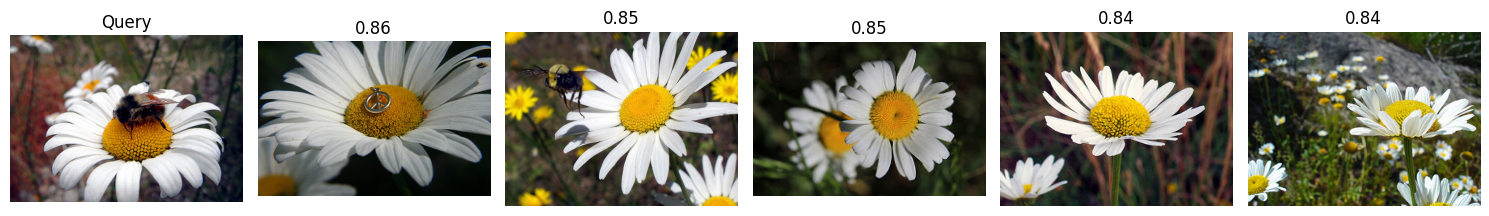

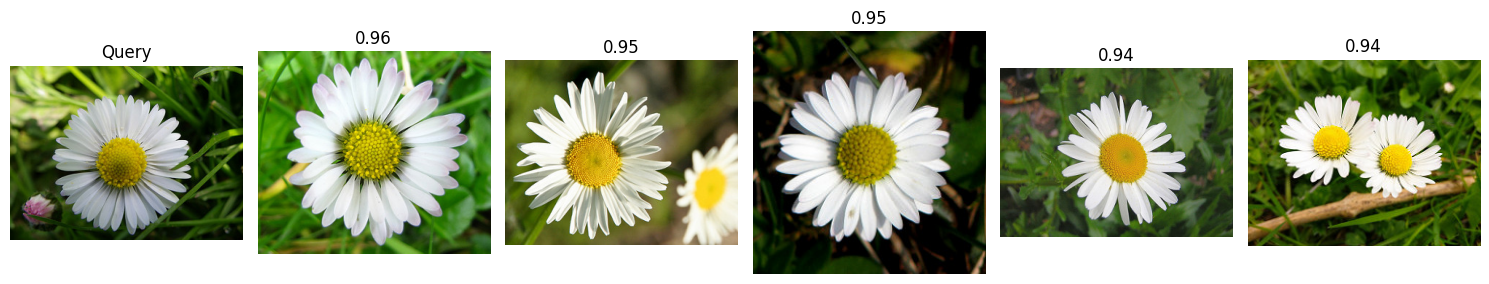

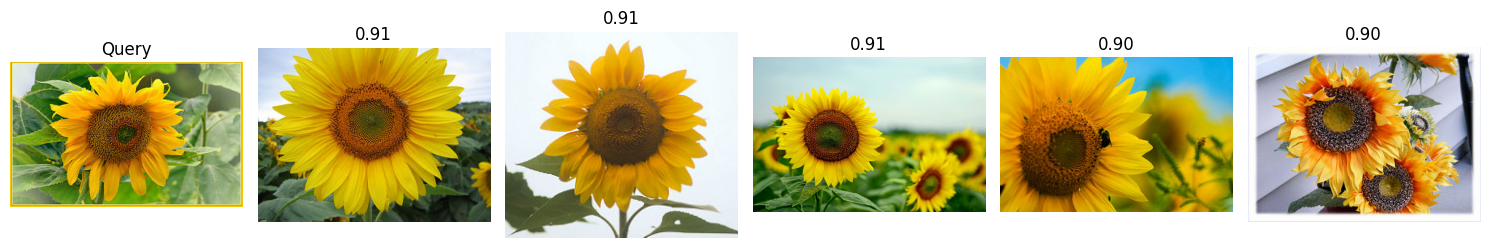

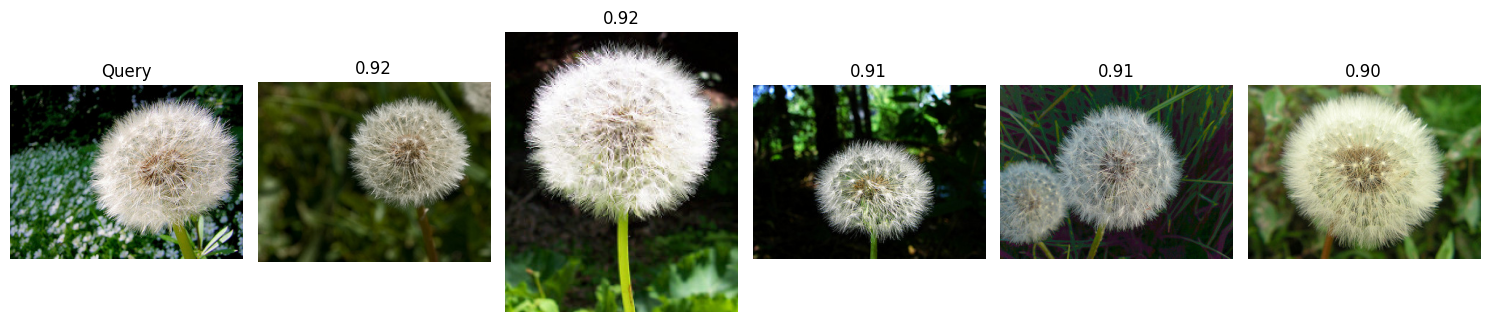

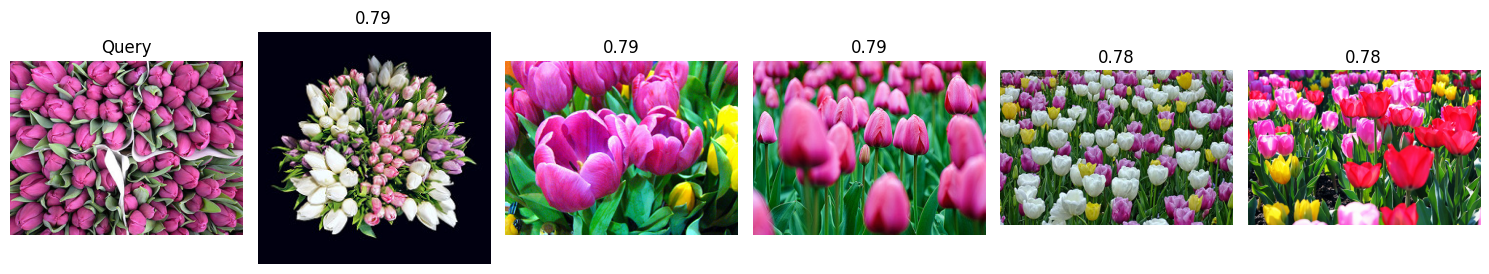

In [17]:
# Примеры
for query in query_paths:
    emb = get_embedding(query)
    top_k = find_top_k(emb, library_embeddings, library_paths, k=5)
    show_query_and_results(query, top_k)